# Durable Consumption Model

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass
from consav import linear_interp
from consav.grids import nonlinspace # grids

import numba as nb
nb.set_num_threads(8)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [2]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

keep->adjust -4.019688418624709
keep->adjust -6.770812842888754
keep->adjust -7.728125449259946
keep->adjust -3.590251020680471
keep->adjust -9.662544874883595
keep->adjust -6.654246484775485
keep->adjust -4.954489190424028
keep->adjust -9.068866174976957
keep->adjust -3.5355871113894177
keep->adjust -3.949360367073772
keep->adjust -3.616457252515014
keep->adjust -5.029161405421802
keep->adjust -1.820136113019812
keep->adjust -9.058273482197158
keep->adjust -1.6516476553198445
keep->adjust -4.153946478061063
keep->adjust -2.7397289911528677
keep->adjust -2.379244475947583
keep->adjust -5.212138059000012
keep->adjust -8.533577243985176
keep->adjust -3.5875568891597243
keep->adjust -3.2877531259979493
keep->adjust -7.012079658408603
keep->adjust -8.550562668033423
keep->adjust -4.384229809592172
keep->adjust -7.091125780526601
keep->adjust -2.6320292532838794
keep->adjust -7.630767613771972
keep->adjust -4.986117625621494
keep->adjust -3.1669200438762033
keep->adjust -6.1281187184732016


In [4]:
model_negm.sol.q[50,:,:,:].min()

0.017208836219066243

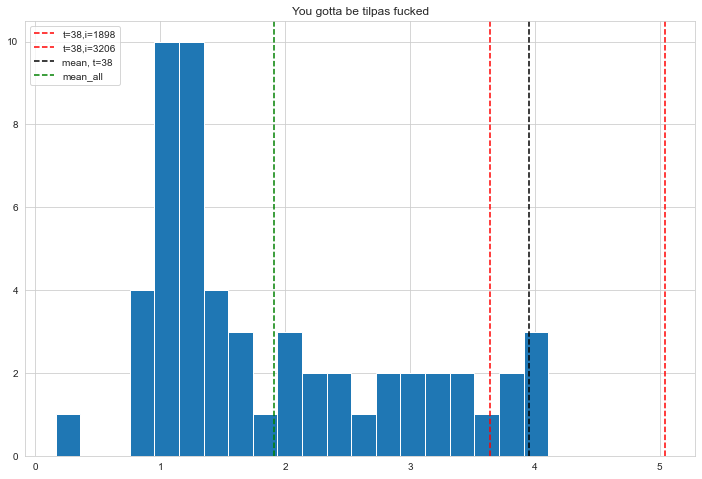

In [5]:
plt.figure(figsize=(12,8))
plt.title('You gotta be tilpas fucked')
plt.hist((np.mean(model_negm.sim.m,axis=1)), bins=20);
plt.axvline(model_negm.sim.m[38,1898],color='r',linestyle='--',label='t=38,i=1898')
plt.axvline(model_negm.sim.m[38,3206],color='r',linestyle='--',label='t=38,i=3206')
plt.axvline(np.mean(model_negm.sim.m,axis=1)[38],color='k',linestyle='--',label='mean, t=38')
plt.axvline(np.mean(model_negm.sim.m),color='g',linestyle='--',label='mean_all')
plt.legend()
plt.show();

**Plot** interactive decision functions:

In [6]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

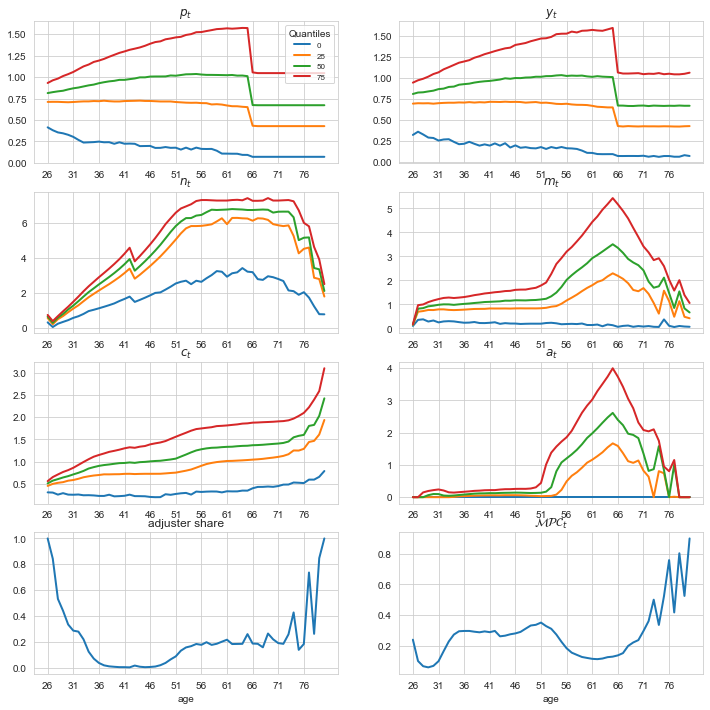

In [8]:
model_negm.lifecycle(deciles=True)

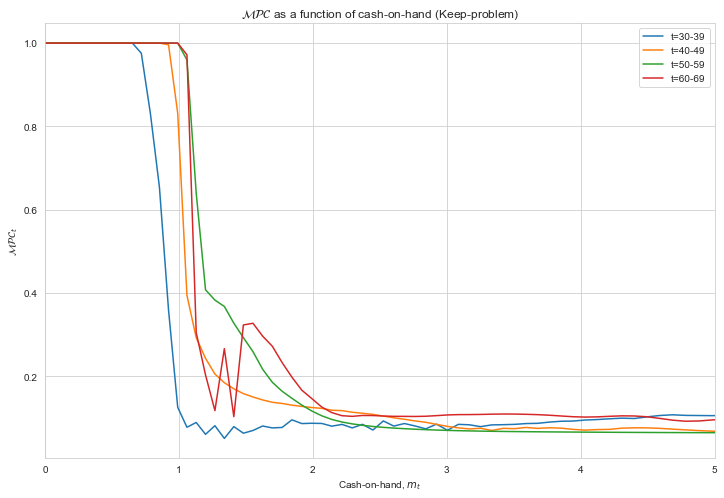

In [9]:
model_negm.mpc_over_cash_on_hand()

In [ ]:
model_negm.sim.mpc.mean()

In [ ]:
import pandas as pd

I = model_negm.sim.mpc < -0.5
df = pd.DataFrame(model_negm.sim.mpc[I])
df

In [ ]:
# plot mpc as a function of cash-on-hand for given t
p_bar = np.mean(model_negm.sim.p,axis=1)
n_bar = np.mean(model_negm.sim.n,axis=1)

c0 = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))
c1 = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))
mpc = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))

m_grid =  nonlinspace(0,model_negm.par.m_max,model_negm.par.Nm,1.1) # model_negm.par.grid_m

for t in range(model_negm.par.T):
    t = int(t)    
    for i,m in enumerate(m_grid):
        #m_int = int(m)
        c0[t,i] = linear_interp.interp_3d(
                model_negm.par.grid_p,model_negm.par.grid_n,model_negm.par.grid_m,model_negm.sol.c_keep[t],  #.sim.c[t],  
                p_bar[t],n_bar[t],m)
        c1[t,i] = linear_interp.interp_3d(
                model_negm.par.grid_p,model_negm.par.grid_n,model_negm.par.grid_m,model_negm.sol.c_keep[t],  #sim.c[t], 
                p_bar[t],n_bar[t],m+model_negm.par.mpc_eps)
        mpc[t,i] = (c1[t,i]-c0[t,i])/model_negm.par.mpc_eps

plt.figure(figsize=(12,8))
for t in np.arange(0,model_negm.par.T,10):
    plt.plot(model_negm.par.grid_m,np.mean(mpc[t:t+4,:],axis=0),label='t={}-{}'.format(t+model_negm.par.Tmin,t+model_negm.par.Tmin+4))
plt.xlim(0,2)
plt.xlabel('Cash-on-hand, $m_t$')
plt.ylabel('$\mathcal{MPC}_t$')
plt.title('$\mathcal{MPC}$ as a function of cash-on-hand (Keep-problem)')
plt.legend()
plt.show()

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [ ]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':True})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

**Plot** interactive decision functions:

In [ ]:
model_nvfi.decision_functions()

**Plot** life-cycle profiles:

In [ ]:
model_nvfi.lifecycle(deciles=True)

# Compare life-cycles from NVFI and NEGM

In [ ]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [ ]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

In [ ]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')